# InceptionV3 Model for Cell Classification

This notebook implements an InceptionV3-based deep learning model for classifying cell images into tumor, non-tumor, and empty categories.

## Setup and Imports

In [3]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc, confusion_matrix, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import gc
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import pandas as pd
import shutil
from collections import defaultdict

# Set GPU memory growth to avoid allocating all memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU devices and enabled memory growth")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")


SEED = 3888
def set_seed(seed=3888):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(SEED)

# Define image size and batch size
IMG_SIZE = 224 

Found 1 GPU devices and enabled memory growth


## Data Preparation

In [4]:
type_to_label_map = {
    'Non-Tumor': 0,
    'Tumor': 1,
    'Empty': 2
}

In [5]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array / 255.0
    
    return img_array

## Model Architecture

In [6]:
def create_inception_model(learning_rate=0.0001, input_shape=(224, 224, 3), seed=3888):
    K.clear_session()
    set_seed(seed)

    # Import Inception V3 model
    from tensorflow.keras.applications import InceptionV3

    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze at first, can be fine-tuned later

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(3, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

## Data Loading Functions

In [7]:
def load_data(dir, target_size=(224, 224)):
    X_data = []
    y_data = []
    

    for quadrant in os.listdir(dir):
        quadrant_path = os.path.join(dir, quadrant)
        X_data_quadrant = []
        y_data_quadrant = []
        
        for cell_type in os.listdir(quadrant_path):
            cell_type_path = os.path.join(quadrant_path, cell_type)
            # print(f"Processing quadrant: {quadrant}, cell type: {cell_type}")
            
            if os.path.isdir(cell_type_path):
                for filename in os.listdir(cell_type_path):
                    if filename.endswith(".png") or filename.endswith(".jpg"):
                        img_path = os.path.join(cell_type_path, filename)
                        img = preprocess_image(img_path, target_size=target_size)
                        # print(img.shape)
                        # print(is_cancer_cell[cell_type])
                        # print(f"Processing image: {img_path}\n")
                        
                        X_data_quadrant.append(img)
                        y_data_quadrant.append(type_to_label_map[cell_type])  
                        
        X_data.append(np.array(X_data_quadrant))
        y_data.append(np.array(y_data_quadrant))

    
    return (X_data, y_data)


## Model Training and Evaluation Functions

In [8]:
def train_full_model(X_datas, y_datas, model_func, model_name, epochs=15, batch_size=8, learning_rate=0.001):
    # Combine all 4 folds of data as training set
    X_train = np.concatenate(X_datas)
    y_train = np.concatenate(y_datas)
    
    # Convert to categorical format
    y_train_cat = to_categorical(y_train, num_classes=3)
    
    print(f"Complete training set shape: {X_train.shape}")
    print(f"Training set label distribution: {np.unique(y_train, return_counts=True)}")
    
    # Create model
    model = model_func(
        learning_rate=learning_rate,
        seed=SEED
    )
    
    # Add early stopping mechanism
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Add model checkpoint for saving
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"{model_name}.h5",
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train, y_train_cat,
        validation_split=0.1,  # Use 10% of data as validation set
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    
    # # Save final model
    # model.save(f"{model_name}_final.h5")
    # print(f"Model saved as {model_name}_final.h5 and {model_name}_best.h5 (best validation accuracy)")
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return trained model and history
    return model, history



## Training on the centered data, testing on the uncentered data

Loading training data...
Training InceptionV3 model and evaluating performance...
Processing quadrant: 1
Training InceptionV3 model and evaluating performance...
Processing quadrant: 1
Complete training set shape: (3196, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1387,  300], dtype=int64))
Complete training set shape: (3196, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1387,  300], dtype=int64))
Epoch 1/20
Epoch 1/20
180/180 [==============================] - ETA: 0s - loss: 0.7547 - accuracy: 0.7497
Epoch 1: val_accuracy improved from -inf to 0.51250, saving model to inceptionv3_test_on_0.h5

Epoch 1: val_accuracy improved from -inf to 0.51250, saving model to inceptionv3_test_on_0.h5
180/180 [==============================] - 36s 53ms/step - loss: 0.7547 - accuracy: 0.7497 - val_loss: 1.2898 - val_accuracy: 0.5125
Epoch 2/20
180/180 [==============================] - 36s 53ms/step - loss: 0.7547 - accuracy: 0.7497 - 

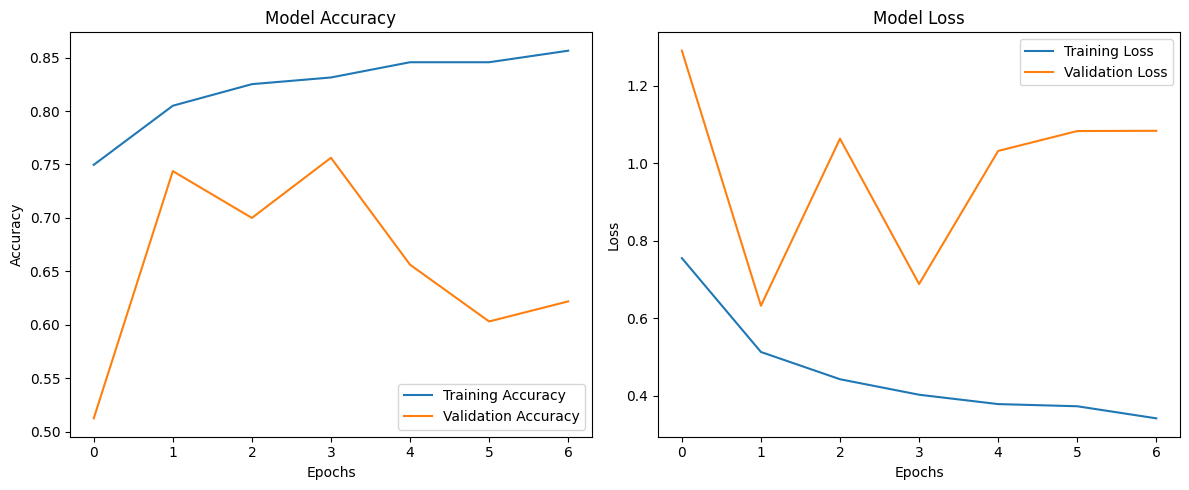

Processing quadrant: 2
Complete training set shape: (3256, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1447,  300], dtype=int64))
Complete training set shape: (3256, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1447,  300], dtype=int64))
Epoch 1/20
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.7279 - accuracy: 0.7410
Epoch 1: val_accuracy improved from -inf to 0.80368, saving model to inceptionv3_test_on_1.h5

Epoch 1: val_accuracy improved from -inf to 0.80368, saving model to inceptionv3_test_on_1.h5
184/184 [==============================] - 12s 49ms/step - loss: 0.7279 - accuracy: 0.7410 - val_loss: 0.6571 - val_accuracy: 0.8037
Epoch 2/20
184/184 [==============================] - 12s 49ms/step - loss: 0.7279 - accuracy: 0.7410 - val_loss: 0.6571 - val_accuracy: 0.8037
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.5022 - accuracy: 0.8040
Epoch 2: val_accuracy did 

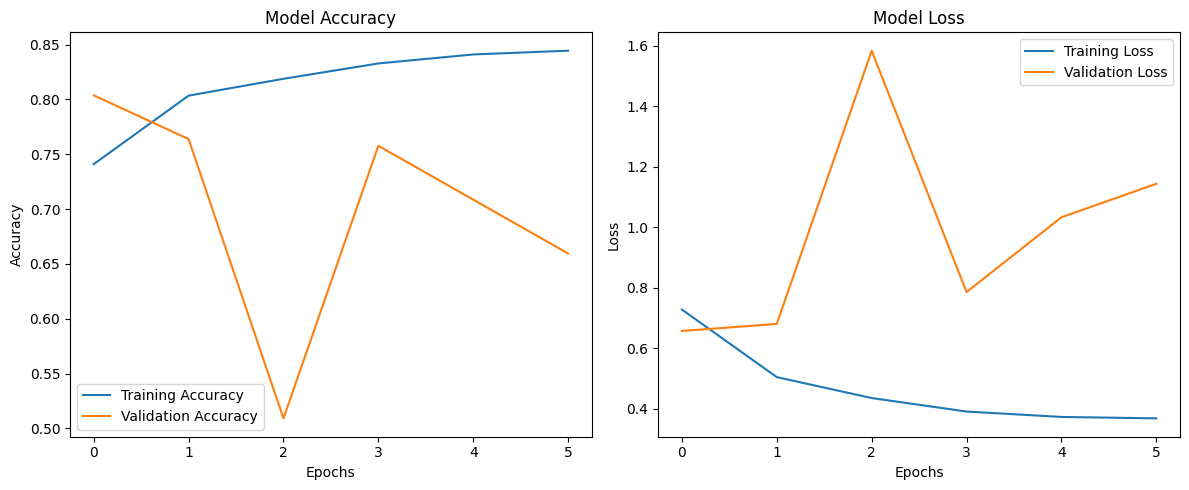

Processing quadrant: 3
Complete training set shape: (3143, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1334,  300], dtype=int64))
Complete training set shape: (3143, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1334,  300], dtype=int64))
Epoch 1/20
Epoch 1/20
177/177 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.7440
Epoch 1: val_accuracy improved from -inf to 0.75873, saving model to inceptionv3_test_on_2.h5

Epoch 1: val_accuracy improved from -inf to 0.75873, saving model to inceptionv3_test_on_2.h5
177/177 [==============================] - 10s 45ms/step - loss: 0.7354 - accuracy: 0.7440 - val_loss: 0.7823 - val_accuracy: 0.7587
Epoch 2/20
177/177 [==============================] - 10s 45ms/step - loss: 0.7354 - accuracy: 0.7440 - val_loss: 0.7823 - val_accuracy: 0.7587
Epoch 2/20
177/177 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.8147
Epoch 2: val_accuracy did 

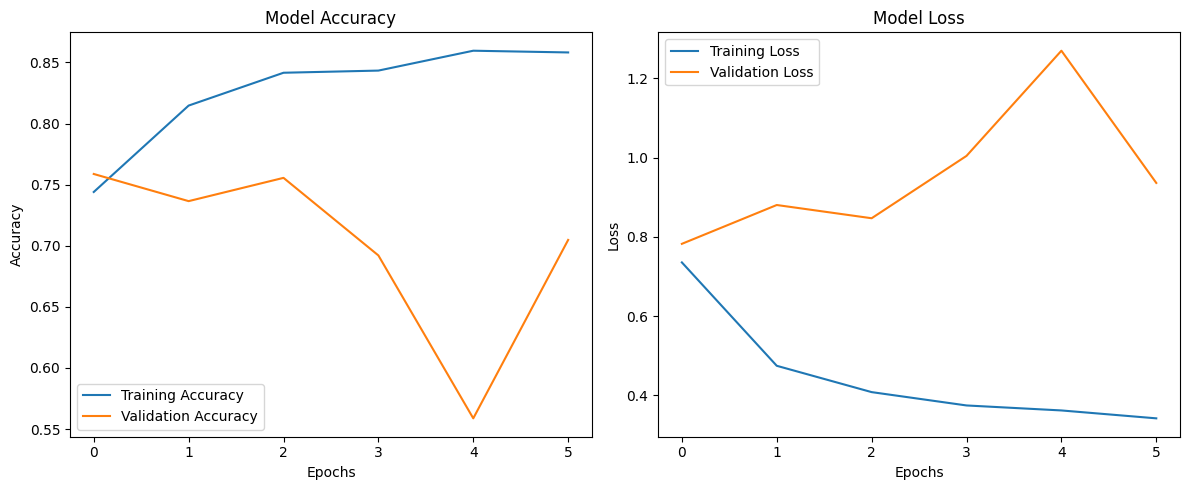

Processing quadrant: 4
Complete training set shape: (3143, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1334,  300], dtype=int64))
Complete training set shape: (3143, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1334,  300], dtype=int64))
Epoch 1/20
Epoch 1/20
177/177 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.7306
Epoch 1: val_accuracy improved from -inf to 0.87302, saving model to inceptionv3_test_on_3.h5

Epoch 1: val_accuracy improved from -inf to 0.87302, saving model to inceptionv3_test_on_3.h5
177/177 [==============================] - 9s 40ms/step - loss: 0.7481 - accuracy: 0.7306 - val_loss: 0.3400 - val_accuracy: 0.8730
Epoch 2/20
177/177 [==============================] - 9s 40ms/step - loss: 0.7481 - accuracy: 0.7306 - val_loss: 0.3400 - val_accuracy: 0.8730
Epoch 2/20
177/177 [==============================] - ETA: 0s - loss: 0.4878 - accuracy: 0.8006
Epoch 2: val_accuracy did no

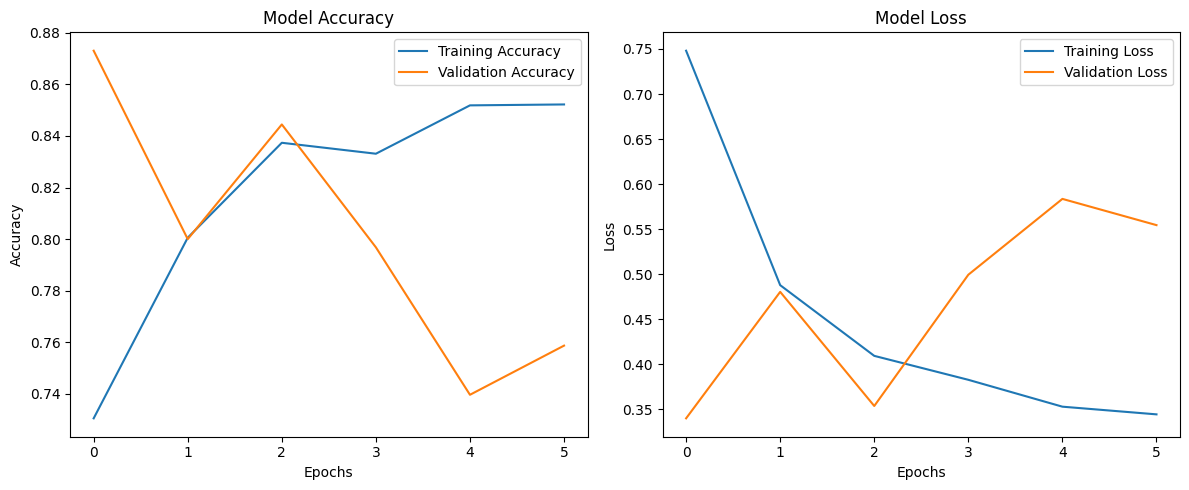

In [ ]:
# Load all 4 folds of data from 100_stratified4fold_1000per_seed3888 as the training set
print("Loading training data...")
X_datas, y_datas = load_data("projectdata/images/100_stratified4fold_1000per_seed3888")



# Set training parameters
inception_full_params = {
    'epochs': 20,         # Increase training epochs
    'batch_size': 16,     # Batch size
    'learning_rate': 0.0005, # Learning rate
}

# Train InceptionV3 model and evaluate
print("Training InceptionV3 model and evaluating performance...")
for quadrant in range(0, 4):
    print(f"Processing quadrant: {quadrant + 1}")
    X_datas_rest = X_datas[:quadrant] + X_datas[quadrant+1:]
    y_datas_rest = y_datas[:quadrant] + y_datas[quadrant+1:]
    
    train_full_model(
        X_datas=X_datas_rest,
        y_datas=y_datas_rest,
        model_func=create_inception_model,
        model_name=f"inceptionv3_test_on_Q{quadrant+1}",
        **inception_full_params
    )
